# Imports

In [1]:
# Standard libraries
import math
import random
from collections import Counter

# External libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from imblearn.combine import SMOTEENN
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, InceptionV3, VGG19
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories

In [2]:
## Set Path Here before running the code
WORKING_DIRECTORY =  "./data/Dataset"

##  Name of classes 
CLASSES = ['Alzheimer',
           'Normal',
           'Parkinson']

# Load img, Rescale, One Hot Encoding

In [3]:
img_target_size = (78, 94)
img_size = (78, 94, 3)

In [4]:
X, y = [], []

## Images rescaling
datagen = ImageDataGenerator(rescale=1.0/255.0)

#   Load images by resizing and shuffling randomly
train_dataset = datagen.flow_from_directory(WORKING_DIRECTORY, target_size=img_target_size,batch_size=6426, shuffle=True)

### Seperate Dataset from  Data Genrator
X, y = train_dataset.next()

Found 7756 images belonging to 3 classes.


In [5]:
samples_before = len(X)
print("Images shape :\t", X.shape)
print("Labels shape :\t", y.shape)

Images shape :	 (6426, 78, 94, 3)
Labels shape :	 (6426, 3)


In [6]:
#   Number of samples in classes 
print("Number of samples in each class:\t", sorted(Counter(np.argmax(y, axis=1)).items()))

#   class labels as per indices
print("Classes Names according to index:\t", train_dataset.class_indices)

Number of samples in each class:	 [(0, 2657), (1, 3021), (2, 748)]
Classes Names according to index:	 {'Alzheimers disease': 0, 'Normal': 1, 'Parkinsons disease': 2}


# Split dataset into Train and Test

In [7]:
#   20% split to validation and 80% split to train set
X_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# Apply Smote-ENN

In [8]:
# Apply SMOTEENN to the flattened data
X_se, y_se = SMOTEENN().fit_resample(X_train.reshape(-1, 78 * 94 * 3), y_train)

# Reshape back to the original image dimensions
X_se = X_se.reshape(-1, 78, 94, 3)

# Split dataset into Train and Validation

In [9]:
#   20% split to test from 80% of train and 60% remains in train set
X_train, x_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.2)
X_se_train, X_se_val, y_se_train, y_se_val = train_test_split(X_se,y_se, test_size = 0.2)

# Number of samples after train test split
print("Number of samples after splitting into Training, validation & test set\n")
print("Number of samples for training before SMOTEENN:\t", sorted(Counter(np.argmax(y_train, axis=1)).items()))
print("Number of samples for training after SMOTEENN:\t", sorted(Counter(np.argmax(y_se_train, axis=1)).items()))
print("Number of samples for validation before SMOTEENN:\t",sorted(Counter(np.argmax(y_val, axis=1)).items()))
print("Number of samples for validation after SMOTEENN:\t",sorted(Counter(np.argmax(y_se_val, axis=1)).items()))
print("Number of samples for testing:\t",sorted(Counter(np.argmax(y_test, axis=1)).items()))

Number of samples after splitting into Training, validation & test set

Number of samples for training before SMOTEENN:	 [(0, 1706), (1, 1918), (2, 488)]
Number of samples for training after SMOTEENN:	 [(0, 1825), (1, 1404), (2, 1899)]
Number of samples for validation before SMOTEENN:	 [(0, 427), (1, 481), (2, 120)]
Number of samples for validation after SMOTEENN:	 [(0, 469), (1, 340), (2, 474)]
Number of samples for testing:	 [(0, 524), (1, 622), (2, 140)]


In [10]:
del X, y #no more needed

# Random samples of original dataset

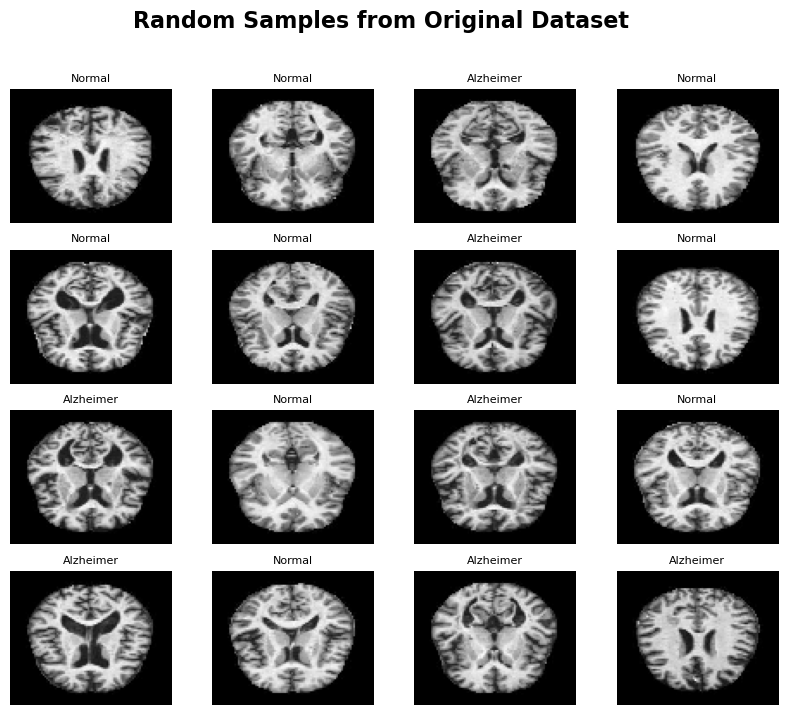

In [11]:
fig = plt.figure(figsize=(10,8))
fig.suptitle("Random Samples from Original Dataset", fontsize=16, fontweight='bold')

rows = 4
columns = 4

for i in range(rows * columns):
    fig.add_subplot(rows, columns, i+1)
    num = random.randint(0, len(X_train)-1 )
    plt.imshow(X_train[num])
    plt.axis('off')
    plt.title(CLASSES[(np.argmax(y_train[num]))], fontsize=8)
plt.axis('off')
plt.show()

# Random samples of generated dataset

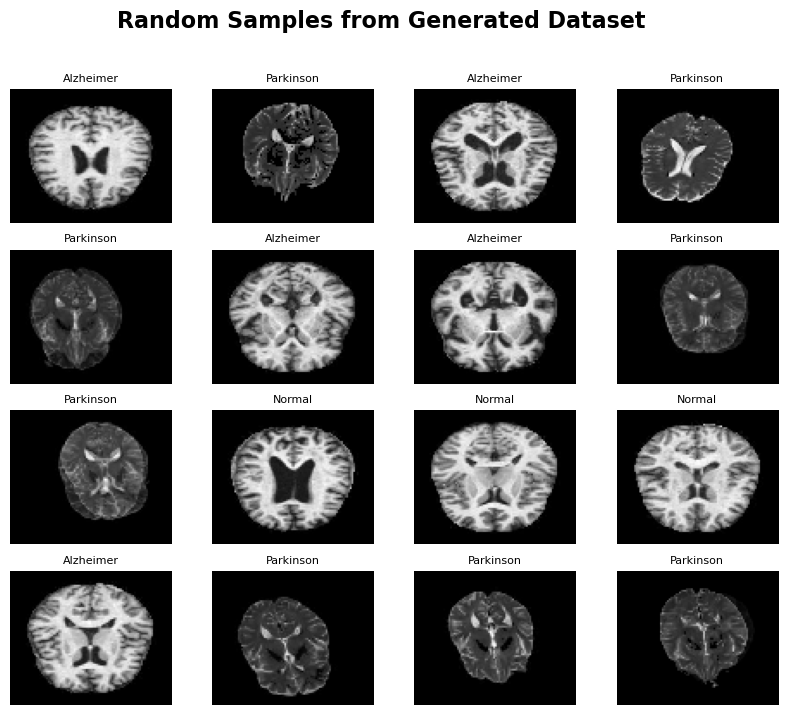

In [12]:
fig = plt.figure(figsize=(10,8))
fig.suptitle("Random Samples from Generated Dataset", fontsize=16, fontweight='bold')

rows = 4
columns = 4

for i in range(rows * columns):
    fig.add_subplot(rows, columns, i+1)
    num = random.randint(0, len(X_se_train) - 1 )
    plt.imshow(X_se_train[num])
    plt.axis('off')
    plt.title(CLASSES[(np.argmax(y_se_train[num]))], fontsize=8)
plt.axis('off')
plt.show()

# Train ResNet50, InceptionV3 & VGG19 Models With SMOTE-ENN

In [13]:
# callbacks used in model to perform well
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=2)

CALLBACKS = [rop_callback]

# ResNet50

In [14]:
# Load the ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=img_size)

# Create a new model on top of the base ResNet50 model
RN50_se_model = Sequential()

# Add the ResNet50 base model
RN50_se_model.add(base_model)

RN50_se_model.add(Dropout(0.10))

RN50_se_model.add(Flatten())

RN50_se_model.add(BatchNormalization())
RN50_se_model.add(Dense(612, activation='relu'))
RN50_se_model.add(Dropout(0.30))

RN50_se_model.add(Dense(356, activation='relu'))
RN50_se_model.add(Dropout(0.30))

RN50_se_model.add(Dense(3, activation='softmax'))

base_model.summary()

RN50_se_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 78, 94, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 84, 100, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 39, 47, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 39, 47, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [15]:
### Model Compilation
RN50_se_model.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") 
       ])

In [16]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 16

RN50_se_history = RN50_se_model.fit(valAug.flow(X_se_train, y_se_train, batch_size=batch_size, shuffle = True),
    validation_data=valAug.flow(X_se_val, y_se_val, batch_size=batch_size, shuffle = True),
    steps_per_epoch = math.ceil(len(X_se_train) / batch_size),
    validation_steps = math.ceil(len(X_se_val) / batch_size),
    epochs= 30,
    batch_size=batch_size,
    callbacks = CALLBACKS
    )

Epoch 1/30
321/321 [==============================] - 34s 74ms/step - loss: 0.4713 - acc: 0.7826 - auc: 0.9372 - precision: 0.7866 - recall: 0.7765 - val_loss: 10.9594 - val_acc: 0.3694 - val_auc: 0.5271 - val_precision: 0.3694 - val_recall: 0.3694 - lr: 0.0100
Epoch 2/30
321/321 [==============================] - 24s 75ms/step - loss: 0.3012 - acc: 0.8621 - auc: 0.9726 - precision: 0.8637 - recall: 0.8612 - val_loss: 5.1920 - val_acc: 0.3694 - val_auc: 0.5351 - val_precision: 0.3694 - val_recall: 0.3694 - lr: 0.0100
Epoch 3/30
321/321 [==============================] - 40s 123ms/step - loss: 0.1924 - acc: 0.9280 - auc: 0.9885 - precision: 0.9285 - recall: 0.9275 - val_loss: 0.5303 - val_acc: 0.7927 - val_auc: 0.9456 - val_precision: 0.7925 - val_recall: 0.7919 - lr: 0.0100
Epoch 4/30
321/321 [==============================] - 29s 92ms/step - loss: 0.1298 - acc: 0.9524 - auc: 0.9947 - precision: 0.9528 - recall: 0.9518 - val_loss: 1.0151 - val_acc: 0.7755 - val_auc: 0.9184 - val_precis

In [17]:
RN50_se_model.save('./ResNet50_SMOTEENN.h5')

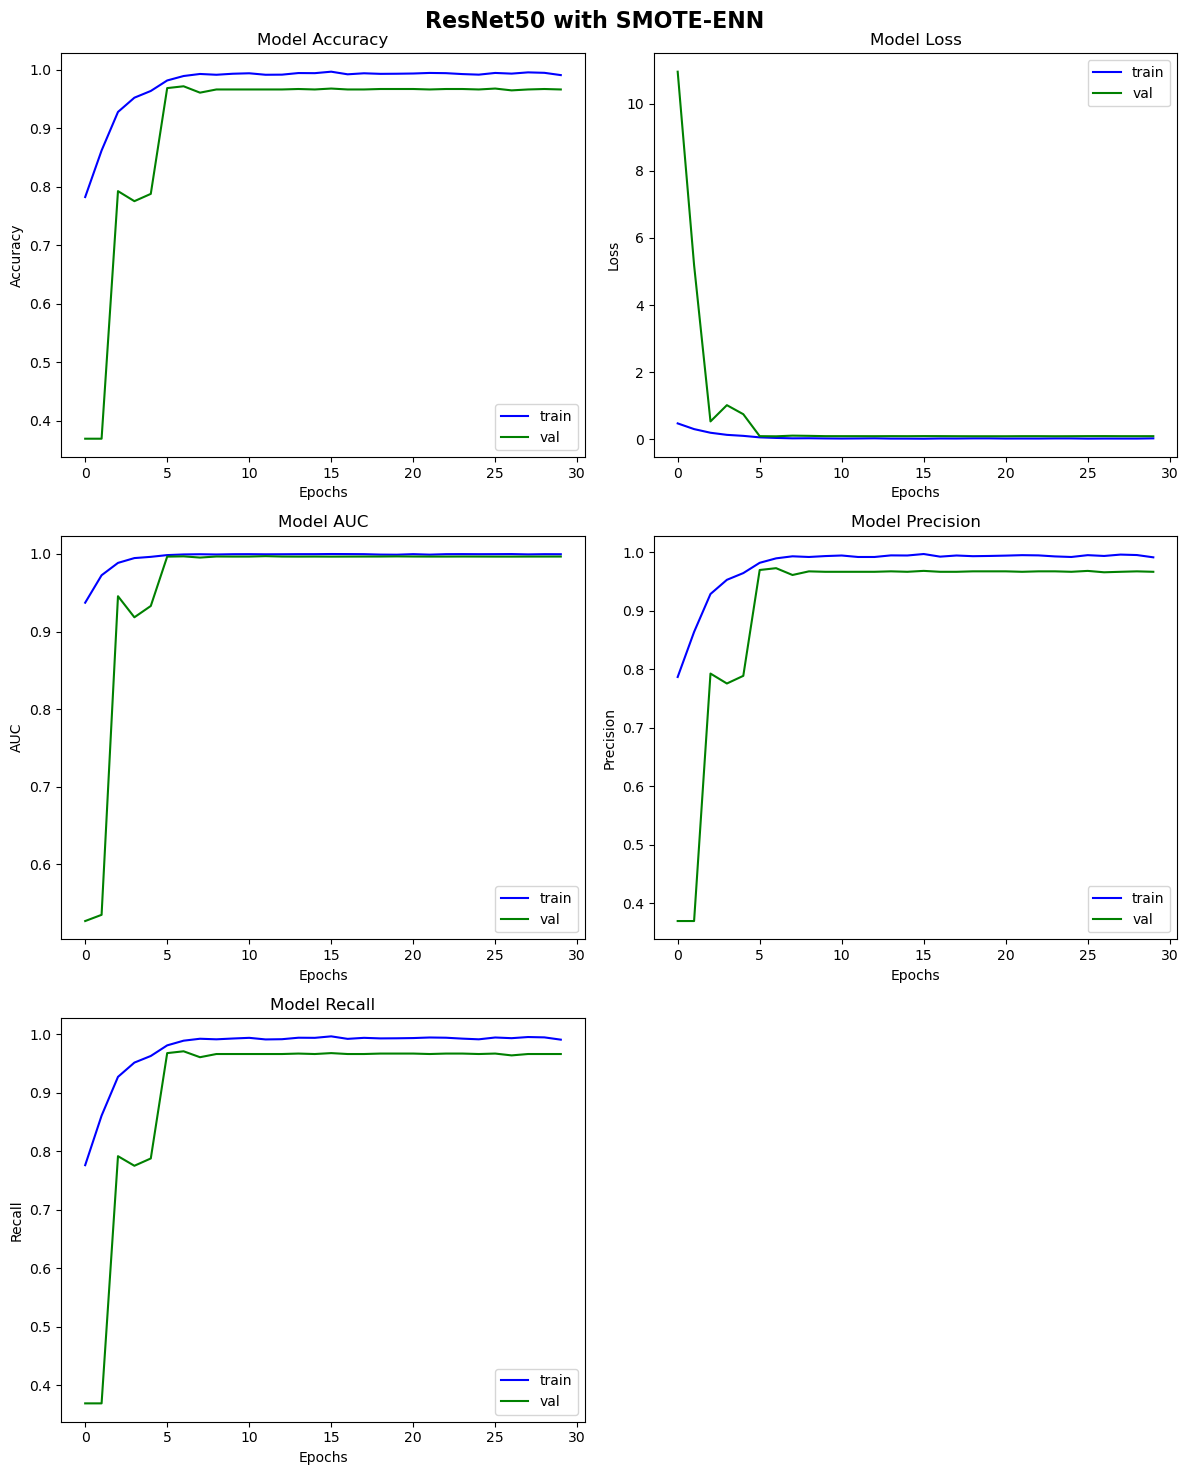

In [18]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
fig.suptitle("ResNet50 with SMOTE-ENN", fontsize=16, fontweight='bold')

# Plot Accuracy
axes[0, 0].plot(RN50_se_history.history['acc'], 'b', label="train")
axes[0, 0].plot(RN50_se_history.history['val_acc'], 'g', label="val")
axes[0, 0].set_title("Model Accuracy")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend()

# Plot Loss
axes[0, 1].plot(RN50_se_history.history['loss'], 'b', label="train")
axes[0, 1].plot(RN50_se_history.history['val_loss'], 'g', label="val")
axes[0, 1].set_title("Model Loss")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()

# Plot AUC
axes[1, 0].plot(RN50_se_history.history['auc'], 'b', label="train")
axes[1, 0].plot(RN50_se_history.history['val_auc'], 'g', label="val")
axes[1, 0].set_title("Model AUC")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("AUC")
axes[1, 0].legend()

# Plot Precision
axes[1, 1].plot(RN50_se_history.history['precision'], 'b', label="train")
axes[1, 1].plot(RN50_se_history.history['val_precision'], 'g', label="val")
axes[1, 1].set_title("Model Precision")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].legend()

# Plot Recall
axes[2, 0].plot(RN50_se_history.history['recall'], 'b', label="train")
axes[2, 0].plot(RN50_se_history.history['val_recall'], 'g', label="val")
axes[2, 0].set_title("Model Recall")
axes[2, 0].set_xlabel("Epochs")
axes[2, 0].set_ylabel("Recall")
axes[2, 0].legend()

# Remove empty subplot (bottom right)
fig.delaxes(axes[2, 1])

# Adjust layout
plt.tight_layout()
plt.show()


# InceptionV3

In [19]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=img_size)

# Create a new model on top of the base VGG19 model
IV3_se_model = Sequential()

# Add the VGG19 base model
IV3_se_model.add(base_model)

IV3_se_model.add(Dropout(0.10))

IV3_se_model.add(Flatten())

IV3_se_model.add(BatchNormalization())
IV3_se_model.add(Dense(612, activation='relu'))
IV3_se_model.add(Dropout(0.30))

IV3_se_model.add(Dense(356, activation='relu'))
IV3_se_model.add(Dropout(0.30))

IV3_se_model.add(Dense(3, activation='softmax'))

base_model.summary()

IV3_se_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 78, 94, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 38, 46, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 38, 46, 32)  96          ['conv2d[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 activation (Activation)        (None, 38, 46, 32)   0           ['batch_normalization_

In [20]:
### Model Compilation
IV3_se_model.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") 
       ])

In [21]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 16

IV3_se_history = IV3_se_model.fit(valAug.flow(X_se_train, y_se_train, batch_size=batch_size, shuffle = True),
    validation_data=valAug.flow(X_se_val, y_se_val, batch_size=batch_size, shuffle = True),
    steps_per_epoch = math.ceil(len(X_se_train) / batch_size),
    validation_steps = math.ceil(len(X_se_val) / batch_size),
    epochs= 30,
    batch_size=batch_size,
    callbacks = CALLBACKS
    )

Epoch 1/30
321/321 [==============================] - 33s 82ms/step - loss: 0.5983 - acc: 0.7151 - auc: 0.9005 - precision: 0.7282 - recall: 0.6934 - val_loss: 0.4683 - val_acc: 0.7701 - val_auc: 0.9350 - val_precision: 0.8016 - val_recall: 0.7023 - lr: 0.0100
Epoch 2/30
321/321 [==============================] - 24s 74ms/step - loss: 0.4359 - acc: 0.7779 - auc: 0.9386 - precision: 0.7817 - recall: 0.7716 - val_loss: 0.5291 - val_acc: 0.6617 - val_auc: 0.8909 - val_precision: 0.6717 - val_recall: 0.6267 - lr: 0.0100
Epoch 3/30
321/321 [==============================] - 25s 77ms/step - loss: 0.3876 - acc: 0.8134 - auc: 0.9520 - precision: 0.8150 - recall: 0.8118 - val_loss: 0.3515 - val_acc: 0.8332 - val_auc: 0.9619 - val_precision: 0.8329 - val_recall: 0.8316 - lr: 0.0100
Epoch 4/30
321/321 [==============================] - 24s 76ms/step - loss: 0.3235 - acc: 0.8500 - auc: 0.9674 - precision: 0.8513 - recall: 0.8493 - val_loss: 0.3043 - val_acc: 0.8698 - val_auc: 0.9710 - val_precisio

In [22]:
IV3_se_model.save('./InceptionV3_SMOTEENN.h5')

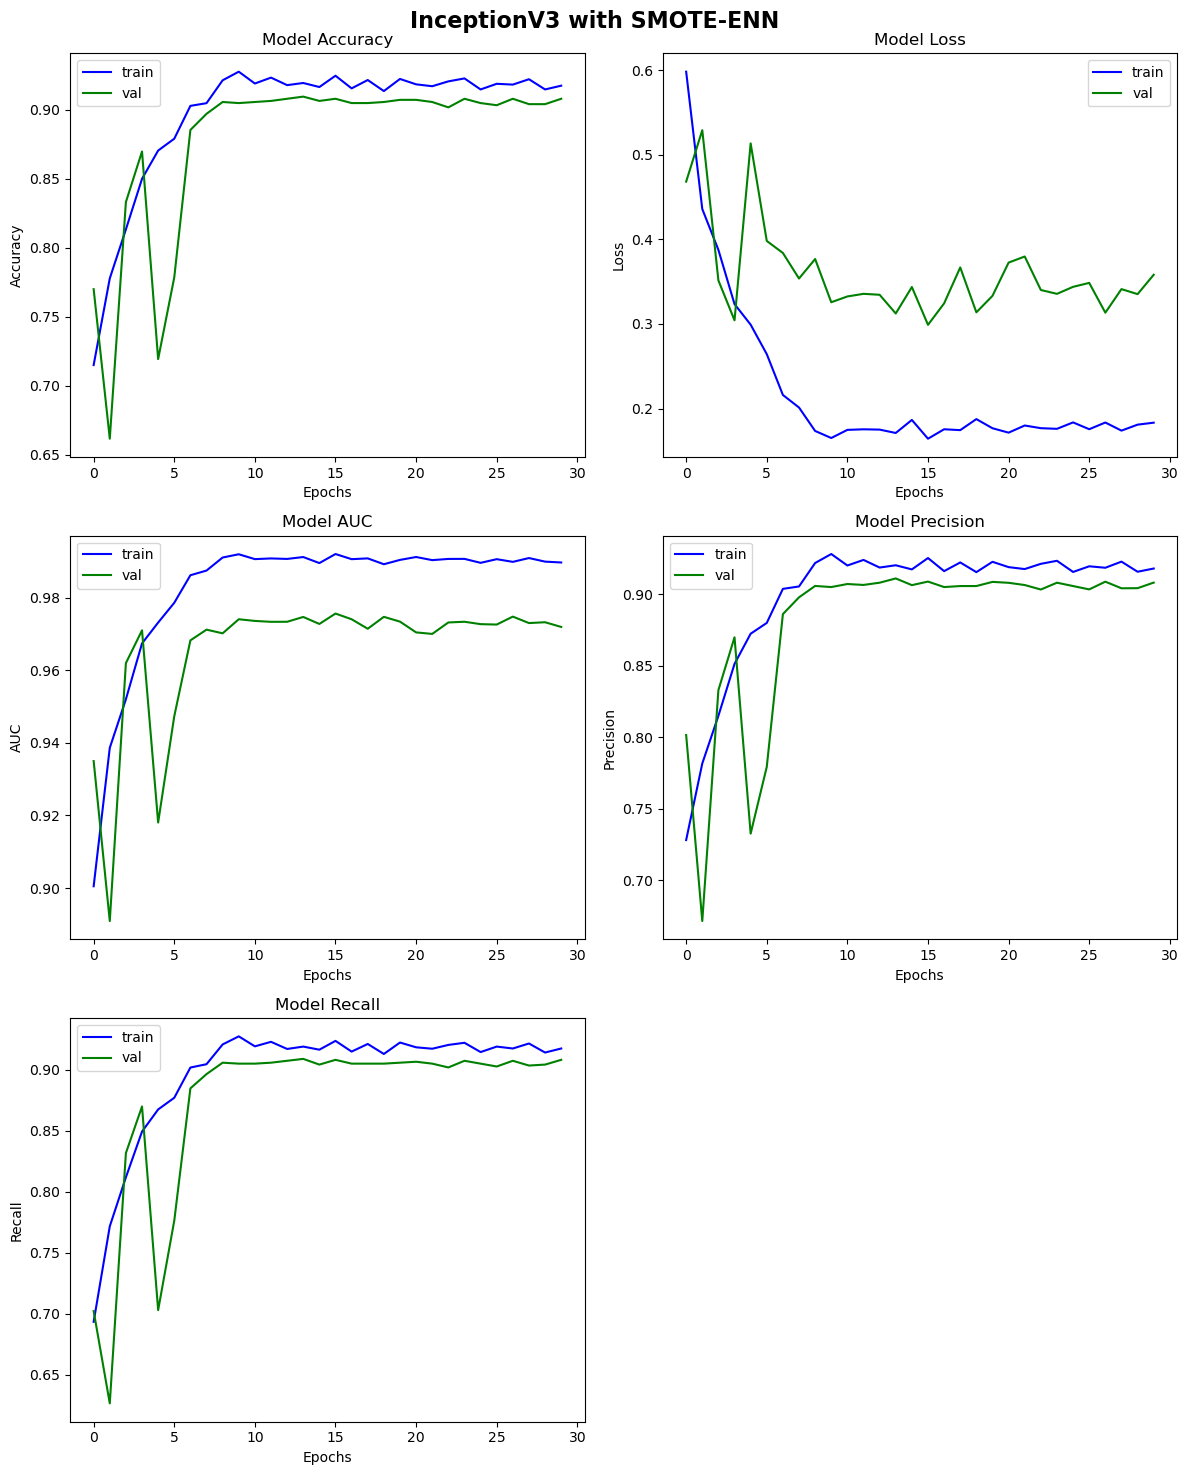

In [23]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
fig.suptitle("InceptionV3 with SMOTE-ENN", fontsize=16, fontweight='bold')

# Plot Accuracy
axes[0, 0].plot(IV3_se_history.history['acc'], 'b', label="train")
axes[0, 0].plot(IV3_se_history.history['val_acc'], 'g', label="val")
axes[0, 0].set_title("Model Accuracy")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend()

# Plot Loss
axes[0, 1].plot(IV3_se_history.history['loss'], 'b', label="train")
axes[0, 1].plot(IV3_se_history.history['val_loss'], 'g', label="val")
axes[0, 1].set_title("Model Loss")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()

# Plot AUC
axes[1, 0].plot(IV3_se_history.history['auc'], 'b', label="train")
axes[1, 0].plot(IV3_se_history.history['val_auc'], 'g', label="val")
axes[1, 0].set_title("Model AUC")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("AUC")
axes[1, 0].legend()

# Plot Precision
axes[1, 1].plot(IV3_se_history.history['precision'], 'b', label="train")
axes[1, 1].plot(IV3_se_history.history['val_precision'], 'g', label="val")
axes[1, 1].set_title("Model Precision")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].legend()

# Plot Recall
axes[2, 0].plot(IV3_se_history.history['recall'], 'b', label="train")
axes[2, 0].plot(IV3_se_history.history['val_recall'], 'g', label="val")
axes[2, 0].set_title("Model Recall")
axes[2, 0].set_xlabel("Epochs")
axes[2, 0].set_ylabel("Recall")
axes[2, 0].legend()

# Remove empty subplot (bottom right)
fig.delaxes(axes[2, 1])

# Adjust layout
plt.tight_layout()
plt.show()


# VGG19

In [24]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=img_size)

# Create a new model on top of the base VGG19 model
V19_se_model = Sequential()

# Add the VGG19 base model
V19_se_model.add(base_model)

V19_se_model.add(Dropout(0.10))

V19_se_model.add(Flatten())

V19_se_model.add(BatchNormalization())
V19_se_model.add(Dense(612, activation='relu'))
V19_se_model.add(Dropout(0.30))

V19_se_model.add(Dense(356, activation='relu'))
V19_se_model.add(Dropout(0.30))

V19_se_model.add(Dense(3, activation='softmax'))

base_model.summary()

V19_se_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 78, 94, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 78, 94, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 78, 94, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 39, 47, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 39, 47, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 39, 47, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 19, 23, 128)       0     

In [25]:
### Model Compilation
V19_se_model.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") 
       ])

In [26]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 16

V19_se_history = V19_se_model.fit(valAug.flow(X_se_train, y_se_train, batch_size=batch_size, shuffle = True),
    validation_data=valAug.flow(X_se_val, y_se_val, batch_size=batch_size, shuffle = True),
    steps_per_epoch = math.ceil(len(X_se_train) / batch_size),
    validation_steps = math.ceil(len(X_se_val) / batch_size),
    epochs= 30,
    batch_size=batch_size,
    callbacks = CALLBACKS
    )

Epoch 1/30
321/321 [==============================] - 33s 89ms/step - loss: 0.5341 - acc: 0.6907 - auc: 0.8982 - precision: 0.7088 - recall: 0.6663 - val_loss: 0.4632 - val_acc: 0.7350 - val_auc: 0.9053 - val_precision: 0.7346 - val_recall: 0.7334 - lr: 0.0100
Epoch 2/30
321/321 [==============================] - 27s 83ms/step - loss: 0.4420 - acc: 0.7568 - auc: 0.9298 - precision: 0.7603 - recall: 0.7504 - val_loss: 0.6362 - val_acc: 0.7350 - val_auc: 0.9224 - val_precision: 0.7367 - val_recall: 0.7350 - lr: 0.0100
Epoch 3/30
321/321 [==============================] - 27s 83ms/step - loss: 0.3952 - acc: 0.7964 - auc: 0.9475 - precision: 0.7988 - recall: 0.7927 - val_loss: 1.0807 - val_acc: 0.6313 - val_auc: 0.9075 - val_precision: 0.6313 - val_recall: 0.6313 - lr: 0.0100
Epoch 4/30
321/321 [==============================] - 28s 87ms/step - loss: 0.3459 - acc: 0.8294 - auc: 0.9618 - precision: 0.8326 - recall: 0.8274 - val_loss: 0.4284 - val_acc: 0.8137 - val_auc: 0.9511 - val_precisio

In [27]:
V19_se_model.save('./VGG19_SMOTEENN.h5')

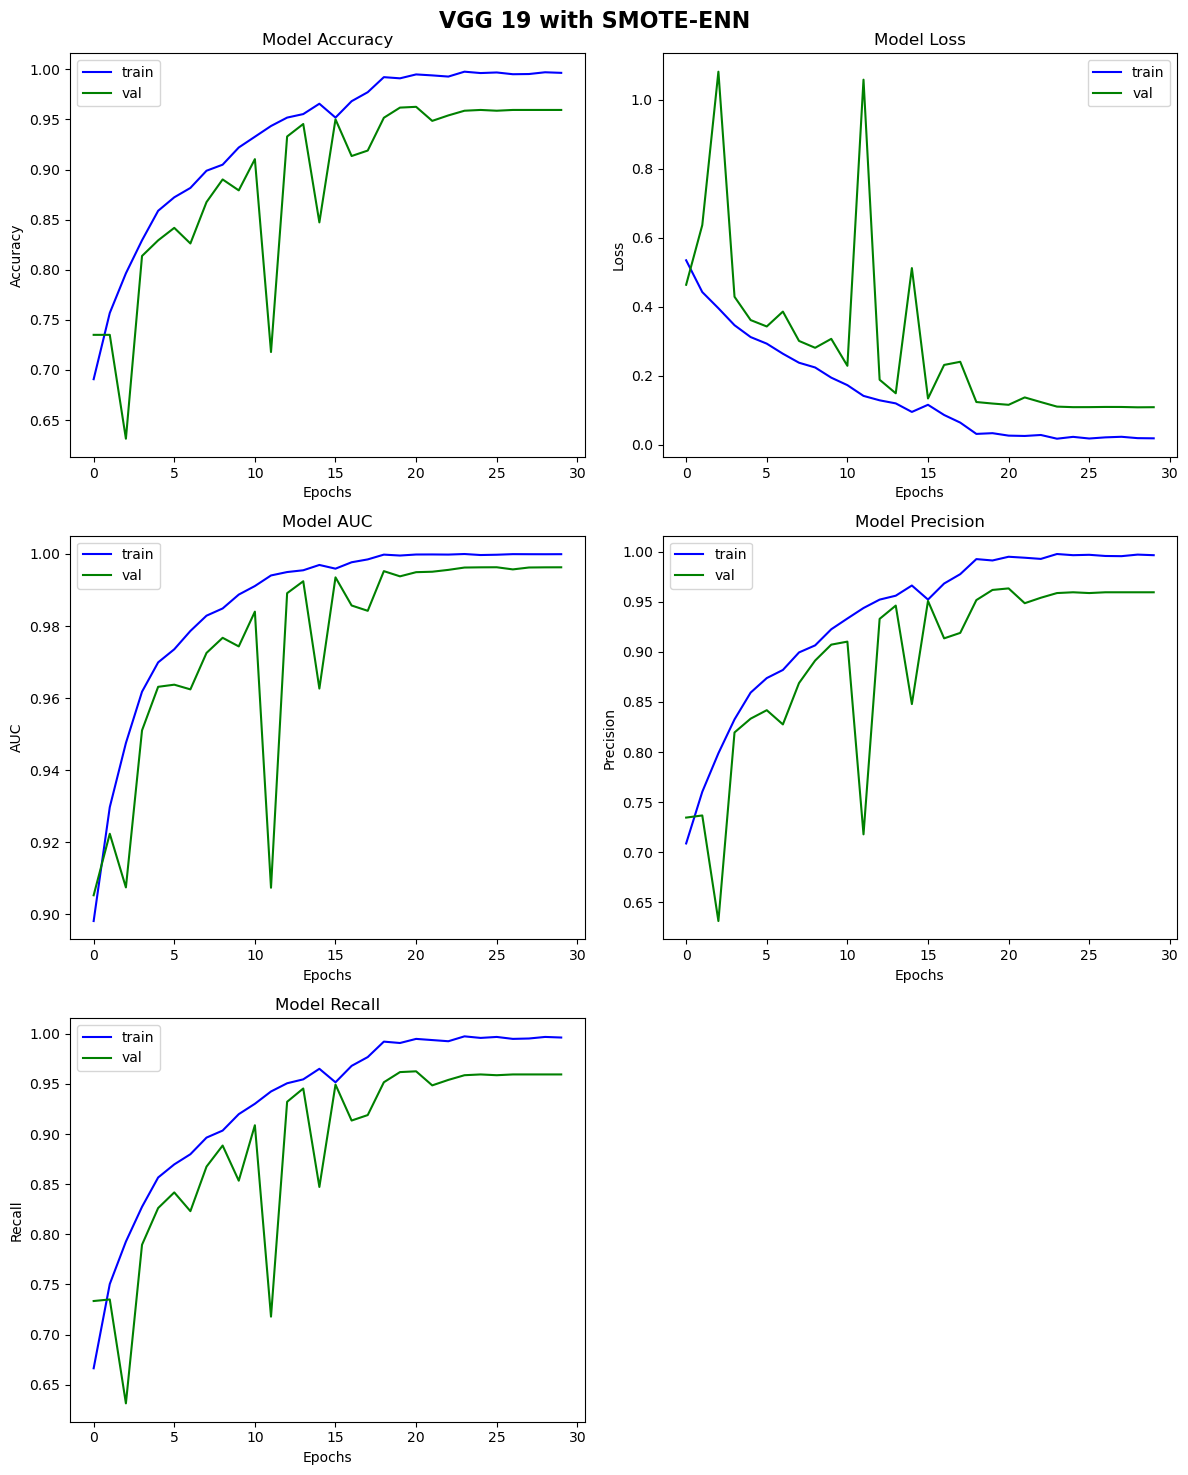

In [28]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
fig.suptitle("VGG 19 with SMOTE-ENN", fontsize=16, fontweight='bold')

# Plot Accuracy
axes[0, 0].plot(V19_se_history.history['acc'], 'b', label="train")
axes[0, 0].plot(V19_se_history.history['val_acc'], 'g', label="val")
axes[0, 0].set_title("Model Accuracy")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend()

# Plot Loss
axes[0, 1].plot(V19_se_history.history['loss'], 'b', label="train")
axes[0, 1].plot(V19_se_history.history['val_loss'], 'g', label="val")
axes[0, 1].set_title("Model Loss")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()

# Plot AUC
axes[1, 0].plot(V19_se_history.history['auc'], 'b', label="train")
axes[1, 0].plot(V19_se_history.history['val_auc'], 'g', label="val")
axes[1, 0].set_title("Model AUC")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("AUC")
axes[1, 0].legend()

# Plot Precision
axes[1, 1].plot(V19_se_history.history['precision'], 'b', label="train")
axes[1, 1].plot(V19_se_history.history['val_precision'], 'g', label="val")
axes[1, 1].set_title("Model Precision")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].legend()

# Plot Recall
axes[2, 0].plot(V19_se_history.history['recall'], 'b', label="train")
axes[2, 0].plot(V19_se_history.history['val_recall'], 'g', label="val")
axes[2, 0].set_title("Model Recall")
axes[2, 0].set_xlabel("Epochs")
axes[2, 0].set_ylabel("Recall")
axes[2, 0].legend()

# Remove empty subplot (bottom right)
fig.delaxes(axes[2, 1])

# Adjust layout
plt.tight_layout()
plt.show()


# Model Evaluation

# Models Training Perfomance Comparision

# Models trained with SMOTE-ENN

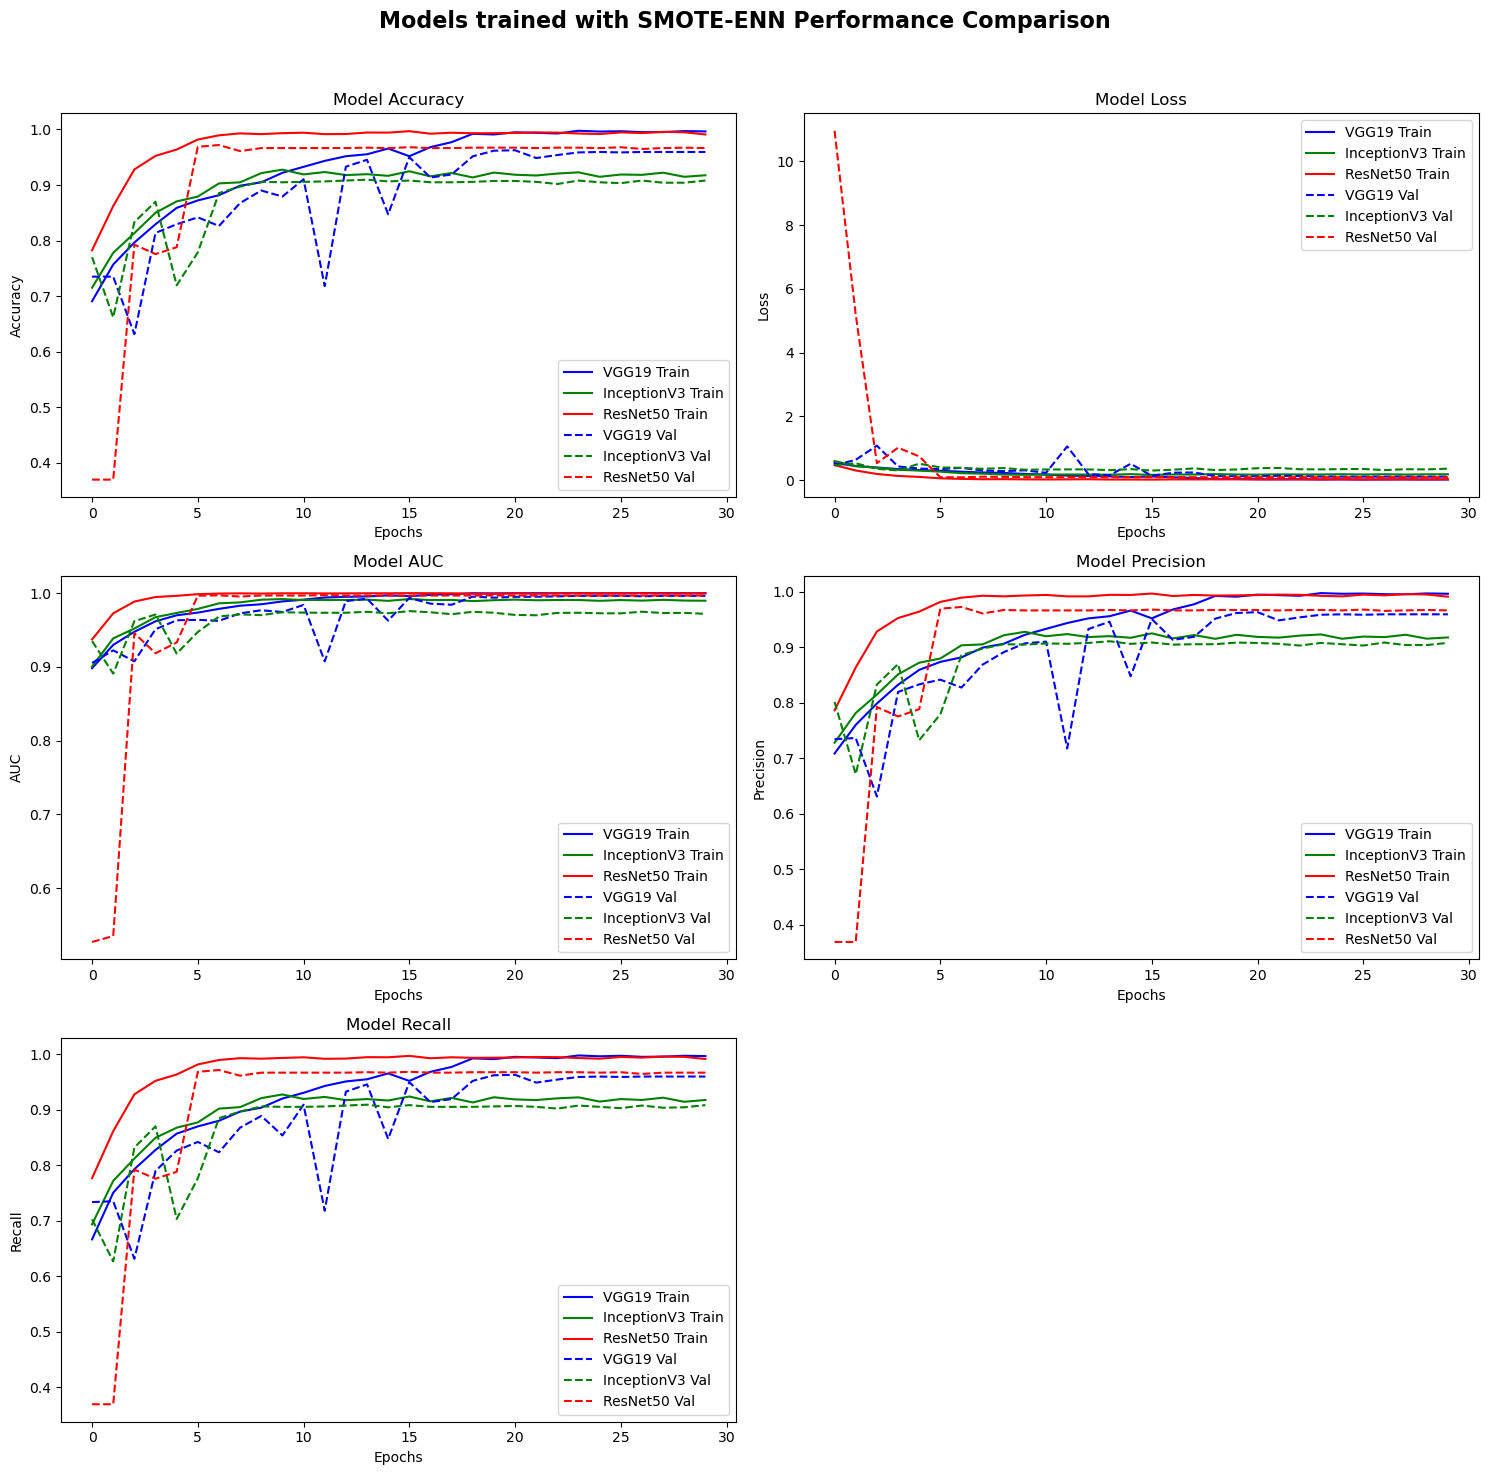

In [29]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # 3 rows, 2 columns
fig.suptitle("Models trained with SMOTE-ENN Performance Comparison", fontsize=16, fontweight='bold')

# Accuracy Plot
axes[0, 0].plot(V19_se_history.history['acc'], 'b', label="VGG19 Train")
axes[0, 0].plot(IV3_se_history.history['acc'], 'g', label="InceptionV3 Train")
axes[0, 0].plot(RN50_se_history.history['acc'], 'r', label="ResNet50 Train")
axes[0, 0].plot(V19_se_history.history['val_acc'], 'b--', label="VGG19 Val")
axes[0, 0].plot(IV3_se_history.history['val_acc'], 'g--', label="InceptionV3 Val")
axes[0, 0].plot(RN50_se_history.history['val_acc'], 'r--', label="ResNet50 Val")
axes[0, 0].set_title("Model Accuracy")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend()

# Loss Plot
axes[0, 1].plot(V19_se_history.history['loss'], 'b', label="VGG19 Train")
axes[0, 1].plot(IV3_se_history.history['loss'], 'g', label="InceptionV3 Train")
axes[0, 1].plot(RN50_se_history.history['loss'], 'r', label="ResNet50 Train")
axes[0, 1].plot(V19_se_history.history['val_loss'], 'b--', label="VGG19 Val")
axes[0, 1].plot(IV3_se_history.history['val_loss'], 'g--', label="InceptionV3 Val")
axes[0, 1].plot(RN50_se_history.history['val_loss'], 'r--', label="ResNet50 Val")
axes[0, 1].set_title("Model Loss")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()

# AUC Plot
axes[1, 0].plot(V19_se_history.history['auc'], 'b', label="VGG19 Train")
axes[1, 0].plot(IV3_se_history.history['auc'], 'g', label="InceptionV3 Train")
axes[1, 0].plot(RN50_se_history.history['auc'], 'r', label="ResNet50 Train")
axes[1, 0].plot(V19_se_history.history['val_auc'], 'b--', label="VGG19 Val")
axes[1, 0].plot(IV3_se_history.history['val_auc'], 'g--', label="InceptionV3 Val")
axes[1, 0].plot(RN50_se_history.history['val_auc'], 'r--', label="ResNet50 Val")
axes[1, 0].set_title("Model AUC")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("AUC")
axes[1, 0].legend()

# Precision Plot
axes[1, 1].plot(V19_se_history.history['precision'], 'b', label="VGG19 Train")
axes[1, 1].plot(IV3_se_history.history['precision'], 'g', label="InceptionV3 Train")
axes[1, 1].plot(RN50_se_history.history['precision'], 'r', label="ResNet50 Train")
axes[1, 1].plot(V19_se_history.history['val_precision'], 'b--', label="VGG19 Val")
axes[1, 1].plot(IV3_se_history.history['val_precision'], 'g--', label="InceptionV3 Val")
axes[1, 1].plot(RN50_se_history.history['val_precision'], 'r--', label="ResNet50 Val")
axes[1, 1].set_title("Model Precision")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].legend()

# Recall Plot
axes[2, 0].plot(V19_se_history.history['recall'], 'b', label="VGG19 Train")
axes[2, 0].plot(IV3_se_history.history['recall'], 'g', label="InceptionV3 Train")
axes[2, 0].plot(RN50_se_history.history['recall'], 'r', label="ResNet50 Train")
axes[2, 0].plot(V19_se_history.history['val_recall'], 'b--', label="VGG19 Val")
axes[2, 0].plot(IV3_se_history.history['val_recall'], 'g--', label="InceptionV3 Val")
axes[2, 0].plot(RN50_se_history.history['val_recall'], 'r--', label="ResNet50 Val")
axes[2, 0].set_title("Model Recall")
axes[2, 0].set_xlabel("Epochs")
axes[2, 0].set_ylabel("Recall")
axes[2, 0].legend()

# Remove the empty subplot (bottom right corner)
fig.delaxes(axes[2, 1])

# Adjust layout to make sure plots don't overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle
plt.show()


# Model Evaluation

In [30]:
# ResNet50 with Smote-Enn
test_scores = RN50_se_model.evaluate(x_test, y_test, batch_size = 2)
precision = test_scores[3]
recall = test_scores[4]
f1_score = 2 * (precision * recall) / (precision + recall)
print("ResNet50 with Smote-Enn:")
print("Testing Accuracy: \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AC: \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing Precision: \t {0:0.6f} %".format(precision * 100))
print("Testing Recall: \t {0:0.6f} %".format(recall * 100))
print("Testing F1-Score: \t {0:0.6f} %".format(f1_score * 100))

# InceptionV3 with Smote-Enn
test_scores = IV3_se_model.evaluate(x_test, y_test, batch_size = 2)
precision = test_scores[3]
recall = test_scores[4]
f1_score = 2 * (precision * recall) / (precision + recall)
print("InceptionV3 with Smote-Enn:")
print("Testing Accuracy: \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AC: \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing Precision: \t {0:0.6f} %".format(precision * 100))
print("Testing Recall: \t {0:0.6f} %".format(recall * 100))
print("Testing F1-Score: \t {0:0.6f} %".format(f1_score * 100))

# VGG19 with Smote-Enn
test_scores = V19_se_model.evaluate(x_test, y_test, batch_size = 2)
precision = test_scores[3]
recall = test_scores[4]
f1_score = 2 * (precision * recall) / (precision + recall)
print("VGG19 with Smote-Enn")
print("Testing Accuracy: \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AC: \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing Precision: \t {0:0.6f} %".format(precision * 100))
print("Testing Recall: \t {0:0.6f} %".format(recall * 100))
print("Testing F1-Score: \t {0:0.6f} %".format(f1_score * 100))

643/643 [==============================] - 11s 14ms/step - loss: 0.7293 - acc: 0.8678 - auc: 0.9431 - precision: 0.8678 - recall: 0.8678
ResNet50 with Smote-Enn:
Testing Accuracy: 	 86.780715 %
Testing AC: 		 94.308585 %
Testing Precision: 	 86.780715 %
Testing Recall: 	 86.780715 %
Testing F1-Score: 	 86.780715 %
643/643 [==============================] - 13s 18ms/step - loss: 0.9406 - acc: 0.7753 - auc: 0.8841 - precision: 0.7751 - recall: 0.7745
InceptionV3 with Smote-Enn:
Testing Accuracy: 	 77.527219 %
Testing AC: 		 88.414758 %
Testing Precision: 	 77.509725 %
Testing Recall: 	 77.449453 %
Testing F1-Score: 	 77.479577 %
643/643 [==============================] - 7s 10ms/step - loss: 0.6541 - acc: 0.8756 - auc: 0.9384 - precision: 0.8756 - recall: 0.8756
VGG19 with Smote-Enn
Testing Accuracy: 	 87.558323 %
Testing AC: 		 93.840212 %
Testing Precision: 	 87.558323 %
Testing Recall: 	 87.558323 %
Testing F1-Score: 	 87.558323 %


In [31]:
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

# ResNet50 with Smote-Enn
RN50_se_pred_labels = RN50_se_model.predict(x_test, batch_size=2)
RN50_se_rounded_pred_labels = [roundoff(labels) for labels in RN50_se_pred_labels]
print("ResNet50 with Smote-Enn:")
print(classification_report(y_test, RN50_se_rounded_pred_labels, target_names=CLASSES))

# InceptionV3 with Smote-Enn
IV3_se_pred_labels = IV3_se_model.predict(x_test, batch_size=2)
IV3_se_rounded_pred_labels = [roundoff(labels) for labels in IV3_se_pred_labels]
print("InceptionV3 with Smote-Enn:")
print(classification_report(y_test, IV3_se_rounded_pred_labels, target_names=CLASSES))

# VGG19 with Smote-Enn
V19_se_pred_labels = V19_se_model.predict(x_test, batch_size=2)
V19_se_rounded_pred_labels = [roundoff(labels) for labels in V19_se_pred_labels]
print("VGG19 with Smote-Enn:")
print(classification_report(y_test, V19_se_rounded_pred_labels, target_names=CLASSES))

643/643 [==============================] - 9s 12ms/step
ResNet50 with Smote-Enn:
              precision    recall  f1-score   support

   Alzheimer       0.88      0.93      0.90       524
      Normal       0.93      0.79      0.85       622
   Parkinson       0.68      0.99      0.81       140

   micro avg       0.87      0.87      0.87      1286
   macro avg       0.83      0.90      0.86      1286
weighted avg       0.88      0.87      0.87      1286
 samples avg       0.87      0.87      0.87      1286

643/643 [==============================] - 13s 18ms/step
InceptionV3 with Smote-Enn:
              precision    recall  f1-score   support

   Alzheimer       0.73      0.90      0.81       524
      Normal       0.88      0.62      0.73       622
   Parkinson       0.69      1.00      0.81       140

   micro avg       0.78      0.78      0.78      1286
   macro avg       0.77      0.84      0.78      1286
weighted avg       0.80      0.78      0.77      1286
 samples avg       